In [1]:
#!/usr/bin/env python
# coding: utf-8

from __future__ import print_function, division
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class miniImage(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, way=5):
        """
        Args:
            mat_file (string): Path to the mat file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotation_csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.way = way
        
        # find class index
        self.class_label, self.class_idx = np.unique(self.annotation_csv['label'], return_index=True)
        self.class_dict = dict(
            zip(self.class_label, range(1, len(self.class_label)+1))
        )
        
        # choose way
        self.way_idx = np.random.choice(self.class_idx, self.way)
        
    def __len__(self):
        return self.class_idx[1]
        
    def __getitem__(self, idx):
        data = []
        label = []
        for i in self.way_idx:
            file_name = self.annotation_csv['filename'][idx+i]
            class_name = self.annotation_csv['label'][idx+i]
            file_path = self.root_dir + '/' + class_name + '/' + file_name
            img = Image.open(file_path)
            # transform
            if self.transform:
                img = self.transform(img)
            # data list
            data.append(img)
            # label list
            label.append(self.class_dict[self.annotation_csv['label'][idx+i]])
            
        data = torch.stack(data, dim=0)
        label = torch.tensor(label)
        sample = {'data':data, 'label':label}
        return sample

In [2]:
csv_file = './mini-imagenet/train.csv'
root_dir = './mini-imagenet/train'

transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = miniImage(csv_file=csv_file,
                     root_dir=root_dir,
                     transform=transform,
                     way=5)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=1, #shot
                                          shuffle=True, 
                                          num_workers=6)

testloader = torch.utils.data.DataLoader(trainset,
                                         batch_size=10,
                                         shuffle=True, 
                                         num_workers=6)

# display sample set

torch.Size([1, 5, 3, 84, 84])
torch.Size([1, 5])
torch.Size([5, 3, 84, 84])


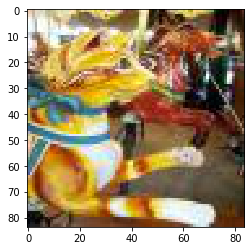

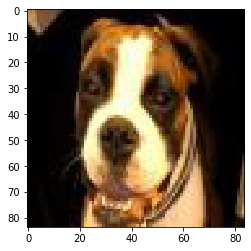

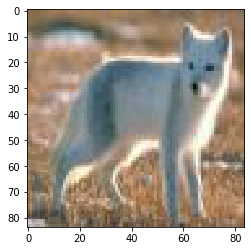

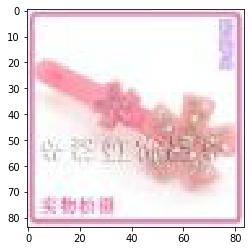

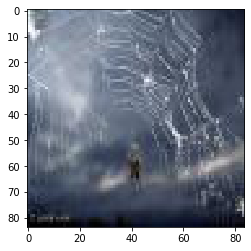

In [20]:
import matplotlib.pyplot as plt
transform = transforms.Compose([
    transforms.ToPILImage()
])

# ['data', 'label'][shot][way][h][w][channel]
for i, sample in enumerate(trainloader):
    # shot
    print(sample['data'].shape)
    print(sample['label'].shape)
    for imgs, labels in zip(sample['data'], sample['label']):
        # every image
        print(imgs.shape)
        for img in imgs:
            img = transform(img)
            plt.imshow(img)
            plt.show()
    break

torch.Size([3, 84, 84])


(array([1239., 1579., 1986., 2833., 3109., 2093., 1890., 1476., 1604.,
        3359.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

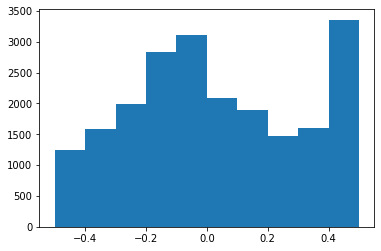

In [29]:
img = trainset[0]['data'][0]
print(img.shape)

transform = transforms.Compose([
    transforms.Normalize([0.5],[1]),
    transforms.RandomErasing(p=0.5, )
])

plt.hist(transform(img).flatten())